# Stock Price Prediction using PySpark

## Introduction

In this project, we developed and evaluated predictive models to analyze and forecast stock prices, with a specific focus on Apple's stock (AAPL). We utilized both linear regression and logistic regression models to achieve different objectives. The linear regression model was employed to predict the continuous closing prices of the stock, while the logistic regression model was used for binary classification based on whether the closing price was above or below the average price. By leveraging data preprocessing techniques, feature engineering, and model evaluation methods, we aimed to build accurate and reliable models that can provide valuable insights into stock price movements.


## Installing PySpark

- **Installation Command**:
  - **`!pip install pyspark`**: Installs the PySpark library, which is an open-source distributed computing system that provides an interface for programming entire clusters with implicit data parallelism and fault tolerance.

- **Usage**:
  - PySpark is used for big data processing and analytics, and can be integrated with various machine learning and data processing workflows in Python.


In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812366 sha256=6db07b1e9ae03435361191fad9603930a3235c38e54866405a7bebc14796b446
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


## Importing Libraries and Initializing Spark Session

- **Libraries**:
  - **`requests`**: For making HTTP requests to fetch data from APIs.
  - **`pandas as pd`**: Used for data manipulation and analysis.
  - **`matplotlib.pyplot as plt`**: For plotting and visualizations.
  - **`pyspark.sql.SparkSession`**: Entry point to use Spark functionality.
  - **`pyspark.sql.types`**: For defining custom data types for Spark DataFrames.
  - **`pyspark.sql.functions`**: For applying functions to Spark DataFrames, such as column operations.
  - **`pyspark.ml.feature`**: Tools for feature engineering in machine learning pipelines.
  - **`pyspark.ml.classification`**: For building classification models.
  - **`pyspark.ml.regression`**: For building regression models.
  - **`pyspark.ml.evaluation`**: For evaluating machine learning models.
  - **`seaborn as sns`**: A Python visualization library based on matplotlib.
  - **`warnings`**: To suppress warnings during execution.

- **Spark Session**:
  - **`spark = SparkSession.builder.appName('StockPricePrediction').getOrCreate()`**: Initializes a Spark session named 'StockPricePrediction', enabling distributed data processing and machine learning with PySpark.


In [2]:
# Import necessary libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, FloatType, DateType
from pyspark.sql.functions import col, mean
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Initialize Spark session
spark = SparkSession.builder.appName('StockPricePrediction').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/15 15:57:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Data Selection & Acquisition

- **API Key and Stock Symbol**:
  - **`API_KEY = '61R16Q7BO31F1QAF'`**: API key for accessing Alpha Vantage's stock data.
  - **`symbol = 'AAPL'`**: Specifies the stock symbol for Apple Inc.

- **API Request**:
  - **`url`**: Constructs the URL for the API request using the stock symbol and API key.
  - **`response = requests.get(url)`**: Sends an HTTP GET request to fetch daily stock data in CSV format.

- **Saving Data**:
  - **`with open('stock_data.csv', 'w') as file:`**: Saves the fetched stock data to a file named `stock_data.csv`.


In [3]:
# Data Selection & Acquisition
API_KEY = '61R16Q7BO31F1QAF'
symbol = 'AAPL'
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={API_KEY}&datatype=csv'
response = requests.get(url)
with open('stock_data.csv', 'w') as file:
    file.write(response.text)

### Defining Schema for Stock Data

- **`schema`**:
  - A **`StructType`** schema defines the structure of the DataFrame, specifying the data types for each column in the stock data CSV.
  
- **Fields**:
  - **`timestamp`**: DateType, stores the date of each stock entry.
  - **`open`**: FloatType, the opening price of the stock.
  - **`high`**: FloatType, the highest price of the stock for the day.
  - **`low`**: FloatType, the lowest price of the stock for the day.
  - **`close`**: FloatType, the closing price of the stock.
  - **`volume`**: FloatType, the trading volume for the day.


In [4]:
# Define schema
schema = StructType([
    StructField("timestamp", DateType(), True),
    StructField("open", FloatType(), True),
    StructField("high", FloatType(), True),
    StructField("low", FloatType(), True),
    StructField("close", FloatType(), True),
    StructField("volume", FloatType(), True)
])

### Loading and Inspecting Stock Data

- **Loading Data**:
  - **`df = spark.read.csv('stock_data.csv', header=True, schema=schema)`**: Loads the stock data from the CSV file into a Spark DataFrame using the predefined schema.

- **Verifying Schema**:
  - **`df.printSchema()`**: Prints the schema of the DataFrame to verify that the data types are correctly assigned according to the schema definition.

- **Showing Sample Data**:
  - **`df.show(5)`**: Displays the first 5 rows of the DataFrame to give a quick preview of the loaded data.


In [5]:
# Load data
df = spark.read.csv('stock_data.csv', header=True, schema=schema)

# Verify the schema and show a sample of the data
df.printSchema()
df.show(5)

root
 |-- timestamp: date (nullable = true)
 |-- open: float (nullable = true)
 |-- high: float (nullable = true)
 |-- low: float (nullable = true)
 |-- close: float (nullable = true)
 |-- volume: float (nullable = true)



+----------+------+--------+------+------+-----------+
| timestamp|  open|    high|   low| close|     volume|
+----------+------+--------+------+------+-----------+
|2024-08-14|220.57|  223.03| 219.7|221.72|4.1960576E7|
|2024-08-13|219.01|  221.89|219.01|221.27|4.4155332E7|
|2024-08-12|216.07|219.5099| 215.6|217.53|3.8028092E7|
|2024-08-09| 212.1|  216.78|211.97|216.24|4.2201648E7|
|2024-08-08|213.11|   214.2|208.83|213.31|4.7161148E7|
+----------+------+--------+------+------+-----------+
only showing top 5 rows



## Data Visualization

### Plotting Stock Data

- **Convert to Pandas DataFrame**:
  - **`pandas_df = df.toPandas()`**: Converts the Spark DataFrame to a Pandas DataFrame for easier plotting.

- **Plotting**:
  - **`pandas_df.plot(x='timestamp', y='close', title='Stock Prices')`**: Creates a line plot of the closing stock prices over time.
  - **`plt.show()`**: Displays the plot.


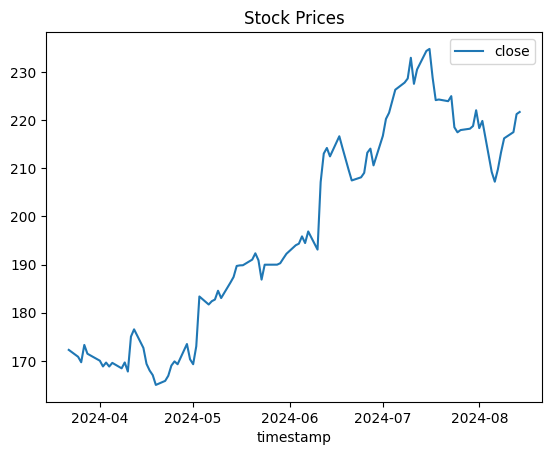

In [6]:
# Plot data
pandas_df = df.toPandas()
pandas_df.plot(x='timestamp', y='close', title='Stock Prices')
plt.show()

## Data Preprocessing

- **Cleaning Data**:
  - **`df = df.dropna().dropDuplicates()`**: Removes any rows with missing values and duplicate rows from the DataFrame.
  - **`print(f"Rows: {df.count()}, Columns: {len(df.columns)}")`**: Prints the number of rows and columns in the cleaned DataFrame.
  - **`df.describe().show()`**: Displays basic statistics (like count, mean, min, max) for each column.

- **Mean Calculation**:
  - **`mean_close = df.select(mean(col('close'))).collect()[0][0]`**: Computes the mean of the 'close' column for later use.

- **Categorical Variable Encoding**:
  - **Dummy Categorical Column**:
    - **`df = df.withColumn('category', (col('close') > mean_close).cast('string'))`**: Creates a new categorical column 'category' based on whether the 'close' value is above or below the mean.
  - **String Indexing**:
    - **`indexer = StringIndexer(inputCol='category', outputCol='categoryIndex')`**: Encodes the 'category' column into numerical indices.
    - **`df = indexer.fit(df).transform(df)`**: Applies the indexer to transform the 'category' column into 'categoryIndex'.
  - **One-Hot Encoding**:
    - **`encoder = OneHotEncoder(inputCol='categoryIndex', outputCol='categoryVec')`**: Converts the 'categoryIndex' into a one-hot encoded vector.
    - **`df = encoder.fit(df).transform(df)`**: Applies the encoder to add the 'categoryVec' column to the DataFrame.


In [7]:
# Data Preprocessing
df = df.dropna().dropDuplicates()
print(f"Rows: {df.count()}, Columns: {len(df.columns)}")
df.describe().show()

# Compute the mean of the 'close' column
mean_close = df.select(mean(col('close'))).collect()[0][0]

# Encode Categorical Variables (add a dummy categorical column for demonstration)
df = df.withColumn('category', (col('close') > mean_close).cast('string'))

# Encode Categorical Variables
indexer = StringIndexer(inputCol='category', outputCol='categoryIndex')
df = indexer.fit(df).transform(df)

encoder = OneHotEncoder(inputCol='categoryIndex', outputCol='categoryVec')
df = encoder.fit(df).transform(df)

Rows: 100, Columns: 6


24/08/15 15:57:17 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+-----------------+-----------------+--------------------+
|summary|              open|              high|              low|            close|              volume|
+-------+------------------+------------------+-----------------+-----------------+--------------------+
|  count|               100|               100|              100|              100|                 100|
|   mean|196.79213882446288|199.03779342651367|194.9922822570801|197.0200001525879|        6.39724332E7|
| stddev|21.819744253094708|22.268716920309167|21.21446452766131|21.83331348266177|3.2508687444710005E7|
|    min|            165.35|             166.4|          164.075|            165.0|         3.4648548E7|
|    max|            236.48|            237.23|           233.09|           234.82|         2.4642136E8|
+-------+------------------+------------------+-----------------+-----------------+--------------------+



## Data Visualizations

### Visualizing the Distribution of Closing Prices

- **Convert to Pandas DataFrame**:
  - **`pandas_df = df.toPandas()`**: Converts the Spark DataFrame to a Pandas DataFrame for easier manipulation and plotting.

- **Plotting the Distribution**:
  - **`plt.figure(figsize=(10, 6))`**: Sets the figure size for the plot.
  - **`sns.histplot(pandas_df['close'], kde=True, color='blue')`**: Creates a histogram of the 'close' prices with a Kernel Density Estimate (KDE) overlay, using blue color.
  - **`plt.title('Distribution of Closing Prices')`**: Adds a title to the plot.
  - **`plt.xlabel('Close Price')`**: Labels the x-axis as "Close Price".
  - **`plt.ylabel('Frequency')`**: Labels the y-axis as "Frequency".
  - **`plt.show()`**: Displays the plot.


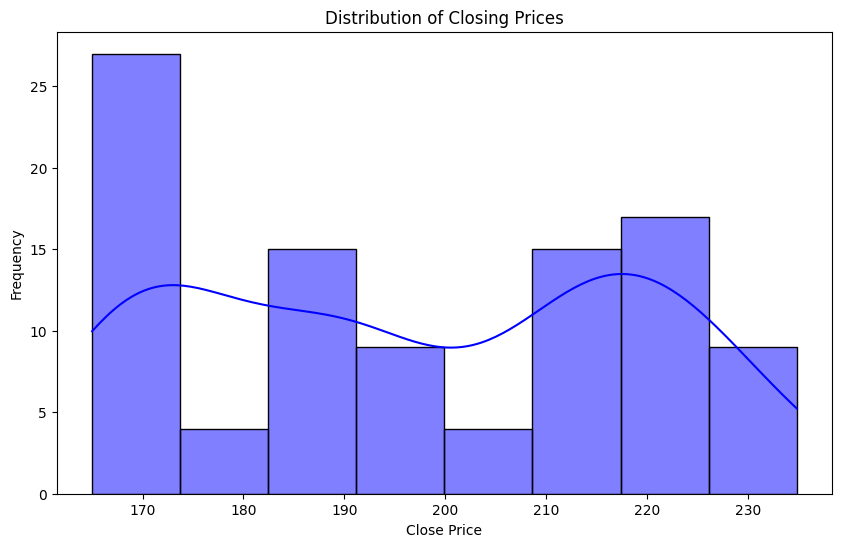

In [8]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
pandas_df = df.toPandas()

# Plot the distribution of closing prices
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df['close'], kde=True, color='blue')
plt.title('Distribution of Closing Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

### Plotting Closing Prices Over Time

- **Line Plot**:
  - **`plt.figure(figsize=(14, 7))`**: Sets the figure size for the plot.
  - **`plt.plot(pandas_df['timestamp'], pandas_df['close'], color='blue')`**: Plots the closing prices over time with the 'timestamp' on the x-axis and 'close' prices on the y-axis.
  - **`plt.title('Closing Prices Over Time')`**: Adds a title to the plot.
  - **`plt.xlabel('Date')`**: Labels the x-axis as "Date".
  - **`plt.ylabel('Close Price')`**: Labels the y-axis as "Close Price".
  - **`plt.show()`**: Displays the plot.


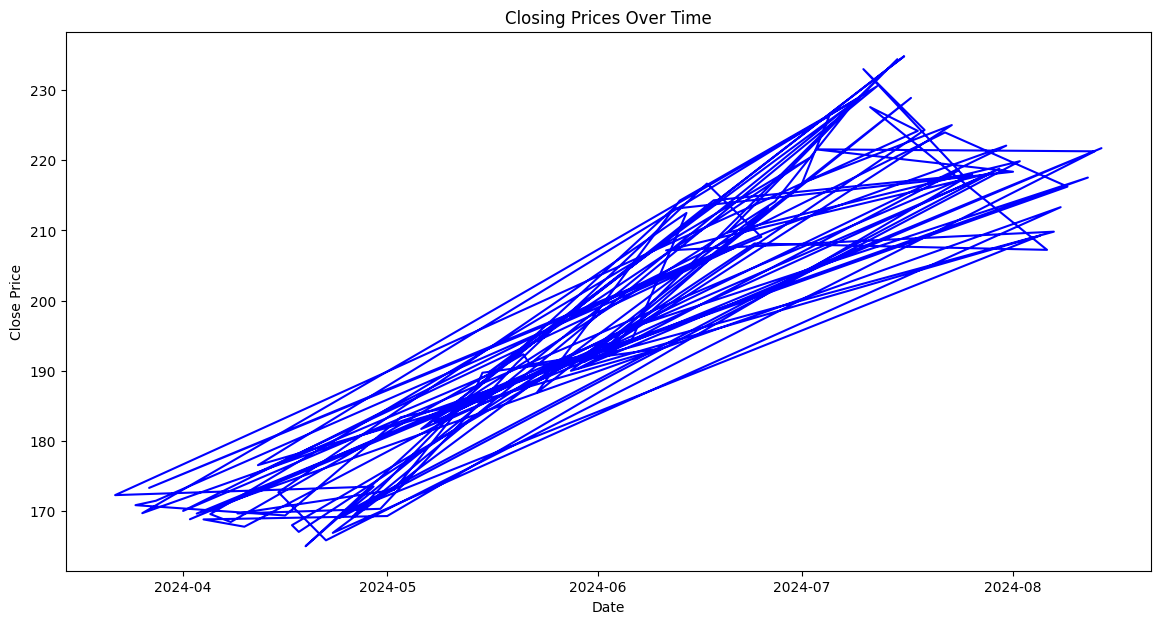

In [9]:
# Plot the closing prices over time
plt.figure(figsize=(14, 7))
plt.plot(pandas_df['timestamp'], pandas_df['close'], color='blue')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

### Correlation Matrix and Heatmap

- **Calculate Correlation Matrix**:
  - **`corr_matrix = pandas_df[['open', 'high', 'low', 'close', 'volume']].corr()`**: Computes the correlation matrix for selected features ('open', 'high', 'low', 'close', 'volume') in the dataset.

- **Plotting the Correlation Heatmap**:
  - **`plt.figure(figsize=(10, 8))`**: Sets the figure size for the heatmap.
  - **`sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)`**: Creates a heatmap of the correlation matrix with annotations, using the 'coolwarm' color map. The values range from -1 to 1.
  - **`plt.title('Correlation Heatmap')`**: Adds a title to the heatmap.
  - **`plt.show()`**: Displays the heatmap.


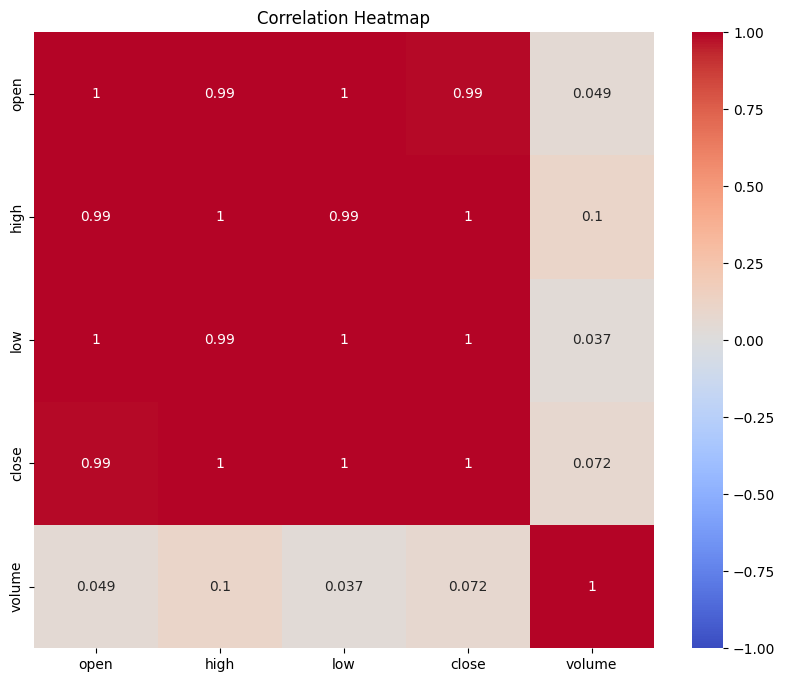

In [10]:
# Calculate correlation matrix
corr_matrix = pandas_df[['open', 'high', 'low', 'close', 'volume']].corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

### Plotting Trading Volume Over Time

- **Line Plot**:
  - **`plt.figure(figsize=(14, 7))`**: Sets the figure size for the plot.
  - **`plt.plot(pandas_df['timestamp'], pandas_df['volume'], color='green')`**: Plots the trading volume over time with the 'timestamp' on the x-axis and 'volume' on the y-axis, using green color for the line.
  - **`plt.title('Trading Volume Over Time')`**: Adds a title to the plot.
  - **`plt.xlabel('Date')`**: Labels the x-axis as "Date".
  - **`plt.ylabel('Volume')`**: Labels the y-axis as "Volume".
  - **`plt.show()`**: Displays the plot.


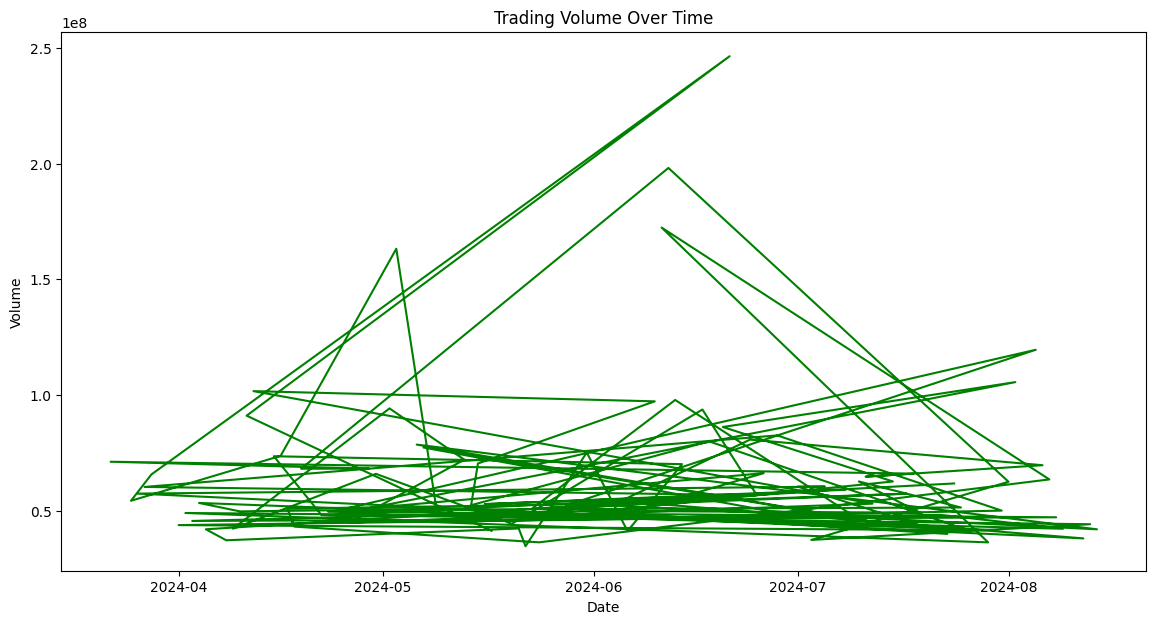

In [11]:
# Plot the volume over time
plt.figure(figsize=(14, 7))
plt.plot(pandas_df['timestamp'], pandas_df['volume'], color='green')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

### Pairplot of Features

- **Pairplot**:
  - **`sns.pairplot(pandas_df[['open', 'high', 'low', 'close', 'volume']])`**: Creates a pairplot to visualize the pairwise relationships between the features 'open', 'high', 'low', 'close', and 'volume'.
  - **`plt.show()`**: Displays the pairplot.


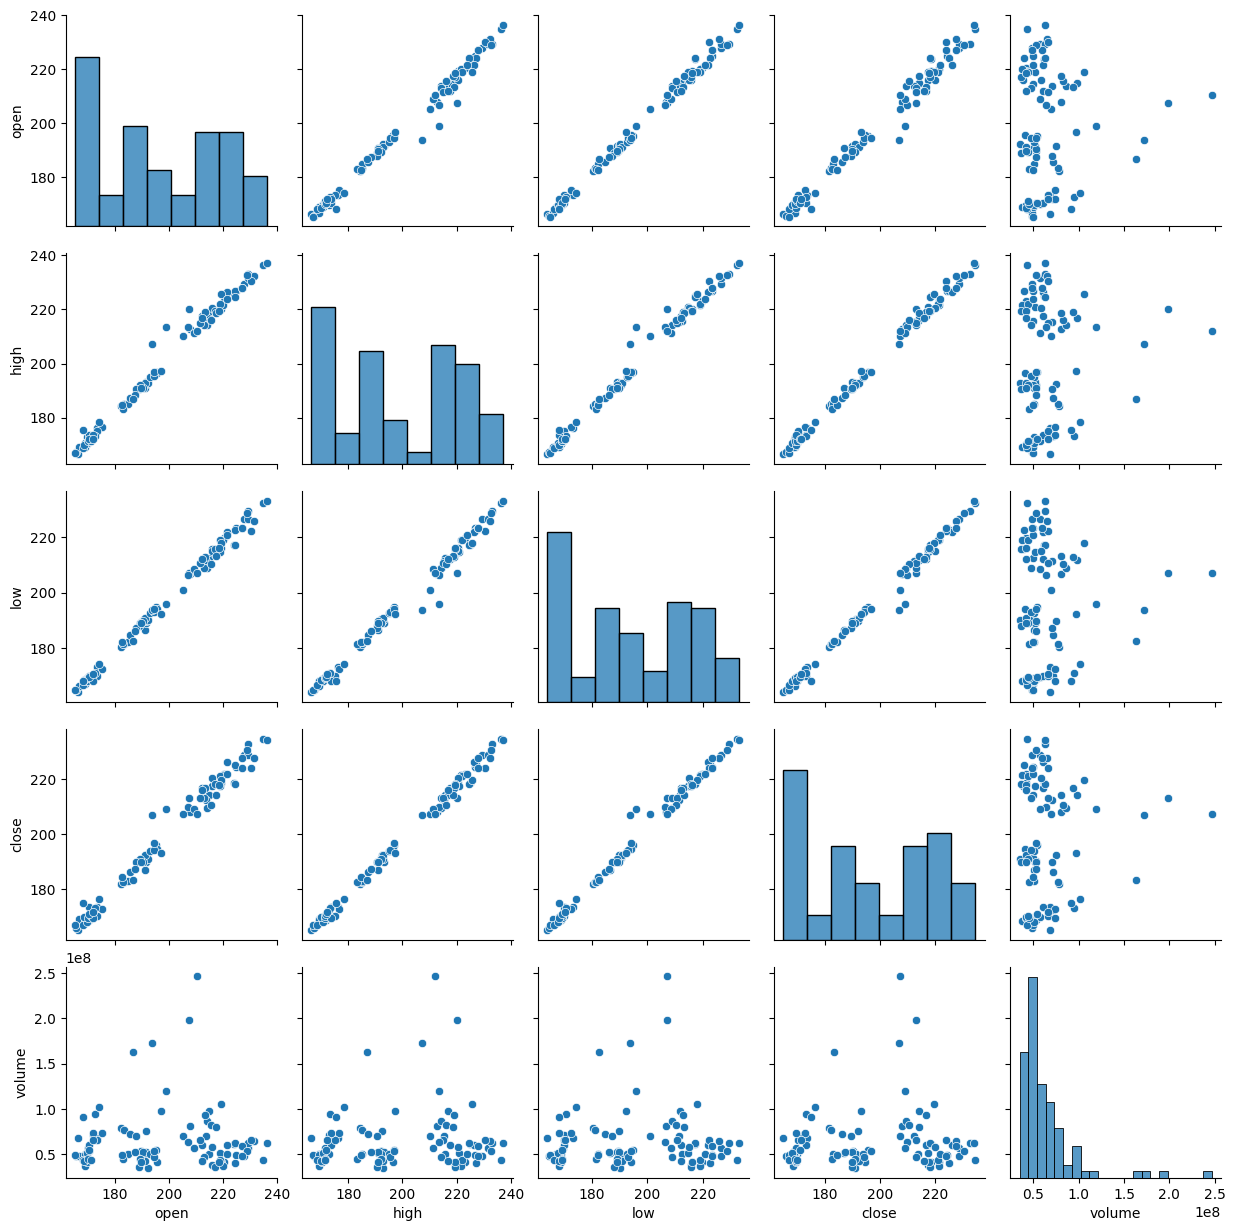

In [12]:
# Plot pairplot to see relationships between features
sns.pairplot(pandas_df[['open', 'high', 'low', 'close', 'volume']])
plt.show()

## Feature Engineering and Scaling

### Data Transformation

- **Feature Vector Assembling**:
  - **`assembler = VectorAssembler(inputCols=['open', 'high', 'low', 'volume', 'categoryVec'], outputCol='features')`**: Combines the specified input columns into a single feature vector called 'features'.
  - **`df = assembler.transform(df)`**: Transforms the DataFrame by creating the 'features' column.

- **Feature Scaling**:
  - **`scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')`**: Initializes a scaler to standardize the feature vector (mean of 0 and variance of 1), outputting the scaled features as 'scaledFeatures'.
  - **`df = scaler.fit(df).transform(df)`**: Fits the scaler on the data and transforms the DataFrame to include the 'scaledFeatures' column.


In [13]:
# Data Transformation
assembler = VectorAssembler(inputCols=['open', 'high', 'low', 'volume', 'categoryVec'], outputCol='features')
df = assembler.transform(df)

scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
df = scaler.fit(df).transform(df)


## Logistic Regression for Binary Classification

- **Label Creation**:
  - **`df = df.withColumn('label', (col('close') > mean_close).cast('integer'))`**: Creates a binary label column 'label' where the value is 1 if the closing price is above the mean and 0 otherwise.

- **Logistic Regression Model**:
  - **`lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='label')`**: Initializes a Logistic Regression model using the 'scaledFeatures' as input and 'label' as the target.
  - **`lr_model = lr.fit(df)`**: Fits the Logistic Regression model to the DataFrame.

- **Model Evaluation**:
  - **`lr_predictions = lr_model.transform(df)`**: Uses the model to make predictions on the DataFrame.
  - **`lr_evaluator = BinaryClassificationEvaluator(labelCol='label')`**: Initializes an evaluator for binary classification.
  - **`lr_accuracy = lr_evaluator.evaluate(lr_predictions)`**: Calculates and prints the accuracy of the Logistic Regression model.


In [14]:
# Logistic Regression (Binary Classification)
df = df.withColumn('label', (col('close') > mean_close).cast('integer'))

lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='label')
lr_model = lr.fit(df)

# Logistic Regression Evaluation
lr_predictions = lr_model.transform(df)
lr_evaluator = BinaryClassificationEvaluator(labelCol='label')
lr_accuracy = lr_evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Model Accuracy: {lr_accuracy}")

24/08/15 15:57:34 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Logistic Regression Model Accuracy: 1.0


## Linear Regression for Continuous Prediction

- **Linear Regression Model**:
  - **`lr = LinearRegression(featuresCol='scaledFeatures', labelCol='close')`**: Initializes a Linear Regression model using 'scaledFeatures' as input and 'close' prices as the target variable.
  - **`linear_model = lr.fit(df)`**: Fits the Linear Regression model to the DataFrame.

- **Model Evaluation**:
  - **`linear_predictions = linear_model.transform(df)`**: Uses the model to make predictions on the DataFrame.
  - **`linear_evaluator = RegressionEvaluator(labelCol='close', metricName='rmse')`**: Initializes an evaluator to compute the Root Mean Square Error (RMSE) for regression.
  - **`linear_rmse = linear_evaluator.evaluate(linear_predictions)`**: Calculates and prints the RMSE of the Linear Regression model.


In [15]:
# Linear Regression (Continuous Prediction)
lr = LinearRegression(featuresCol='scaledFeatures', labelCol='close')
linear_model = lr.fit(df)

# Linear Regression Evaluation
linear_predictions = linear_model.transform(df)
linear_evaluator = RegressionEvaluator(labelCol='close', metricName='rmse')
linear_rmse = linear_evaluator.evaluate(linear_predictions)
print(f"Linear Regression Model RMSE: {linear_rmse}")

24/08/15 15:57:38 WARN Instrumentation: [4b27ac01] regParam is zero, which might cause numerical instability and overfitting.
24/08/15 15:57:38 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Linear Regression Model RMSE: 1.0717626560753761


## Visualization of Predictions

### Visualizing Actual vs Predicted Closing Prices for Linear Regression

- **Convert Predictions to Pandas DataFrame**:
  - **`pred_df = linear_predictions.select("timestamp", "close", "prediction").toPandas()`**: Converts the Spark DataFrame containing actual and predicted closing prices to a Pandas DataFrame.

- **Sorting Data**:
  - **`pred_df = pred_df.sort_values('timestamp')`**: Sorts the DataFrame by timestamp to ensure the plot lines are correctly aligned over time.

- **Plotting**:
  - **`plt.figure(figsize=(14, 7))`**: Sets the figure size for the plot.
  - **`plt.plot(pred_df['timestamp'], pred_df['close'], label='Actual Close Prices', color='blue', alpha=0.7)`**: Plots the actual closing prices in blue.
  - **`plt.plot(pred_df['timestamp'], pred_df['prediction'], label='Predicted Close Prices', color='red', linestyle='--', alpha=0.7)`**: Plots the predicted closing prices in red with a dashed line.
  - **`plt.fill_between(pred_df['timestamp'], pred_df['close'], pred_df['prediction'], color='gray', alpha=0.2)`**: Fills the area between the actual and predicted prices with a gray shade to highlight the differences.
  - **`plt.xlabel('Date')`**: Labels the x-axis as "Date".
  - **`plt.ylabel('Close Price')`**: Labels the y-axis as "Close Price".
  - **`plt.title('Linear Regression -- Actual vs Predicted Close Prices')`**: Adds a title to the plot.
  - **`plt.legend()`**: Adds a legend to differentiate between actual and predicted lines.
  - **`plt.show()`**: Displays the plot.


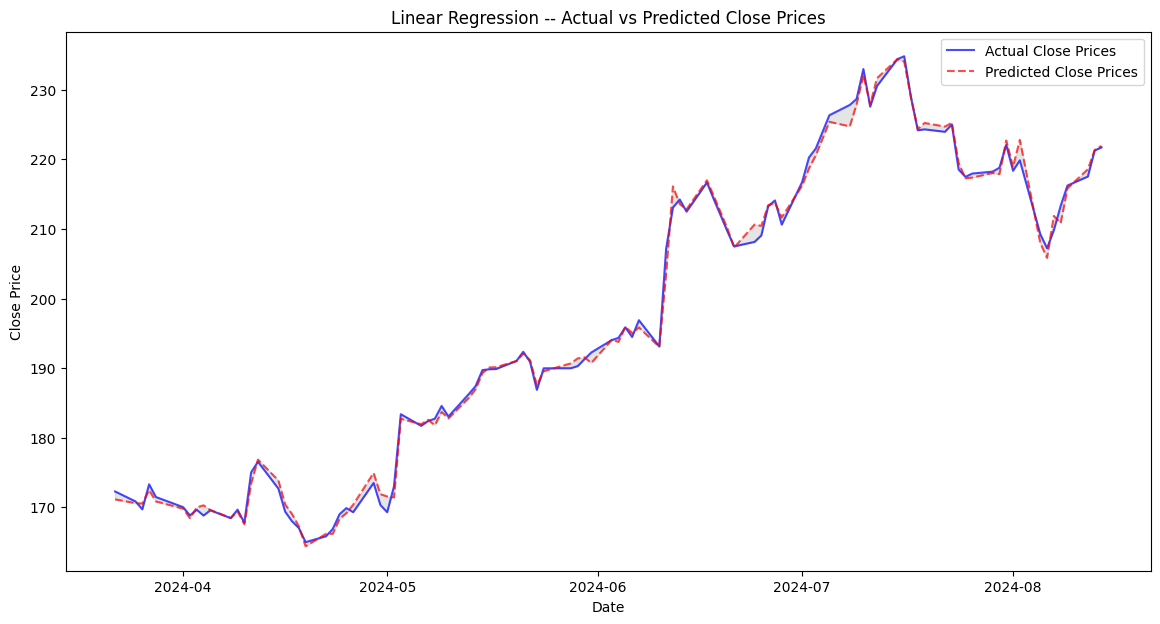

In [16]:
# Convert predictions to Pandas DataFrame for visualization
pred_df = linear_predictions.select("timestamp", "close", "prediction").toPandas()

# Sort by timestamp to ensure the lines are drawn correctly
pred_df = pred_df.sort_values('timestamp')

# Plot actual vs predicted closing prices
plt.figure(figsize=(14, 7))
plt.plot(pred_df['timestamp'], pred_df['close'], label='Actual Close Prices', color='blue', alpha=0.7)
plt.plot(pred_df['timestamp'], pred_df['prediction'], label='Predicted Close Prices', color='red', linestyle='--', alpha=0.7)
plt.fill_between(pred_df['timestamp'], pred_df['close'], pred_df['prediction'], color='gray', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Linear Regression -- Actual vs Predicted Close Prices')
plt.legend()
plt.show()

### Visualizing Actual vs Predicted Closing Prices for Logistic Regression

- **Convert Predictions to Pandas DataFrame**:
  - **`pred_df = lr_predictions.select("timestamp", "close", "prediction").toPandas()`**: Converts the Spark DataFrame containing actual and predicted closing prices from the Logistic Regression model to a Pandas DataFrame.

- **Sorting Data**:
  - **`pred_df = pred_df.sort_values('timestamp')`**: Sorts the DataFrame by timestamp to ensure the plot lines are correctly aligned over time.

- **Plotting**:
  - **`plt.figure(figsize=(14, 7))`**: Sets the figure size for the plot.
  - **`plt.plot(pred_df['timestamp'], pred_df['close'], label='Actual Close Prices', color='blue', alpha=0.7)`**: Plots the actual closing prices in blue.
  - **`plt.plot(pred_df['timestamp'], pred_df['prediction'], label='Predicted Close Prices', color='red', linestyle='--', alpha=0.7)`**: Plots the predicted closing prices in red with a dashed line.
  - **`plt.fill_between(pred_df['timestamp'], pred_df['close'], pred_df['prediction'], color='gray', alpha=0.2)`**: Fills the area between the actual and predicted prices with a gray shade to highlight the differences.
  - **`plt.xlabel('Date')`**: Labels the x-axis as "Date".
  - **`plt.ylabel('Close Price')`**: Labels the y-axis as "Close Price".
  - **`plt.title('Logistic Regression -- Actual vs Predicted Close Prices')`**: Adds a title to the plot.
  - **`plt.legend()`**: Adds a legend to differentiate between actual and predicted lines.
  - **`plt.show()`**: Displays the plot.


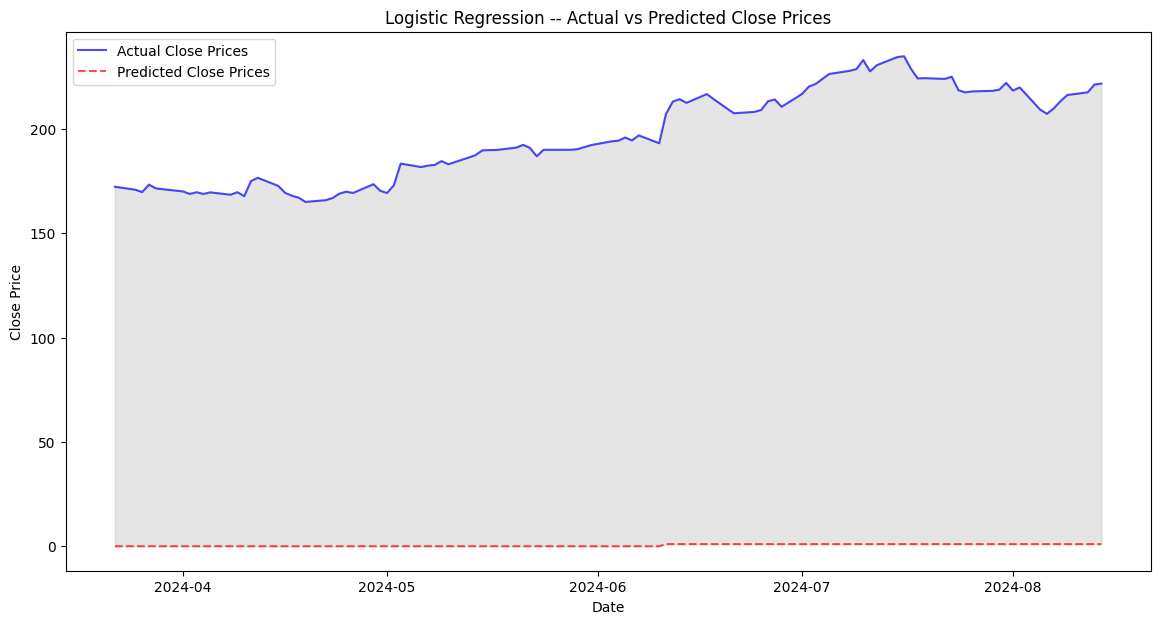

In [17]:
# Convert predictions to Pandas DataFrame for visualization
pred_df = lr_predictions.select("timestamp", "close", "prediction").toPandas()

# Sort by timestamp to ensure the lines are drawn correctly
pred_df = pred_df.sort_values('timestamp')

# Plot actual vs predicted closing prices
plt.figure(figsize=(14, 7))
plt.plot(pred_df['timestamp'], pred_df['close'], label='Actual Close Prices', color='blue', alpha=0.7)
plt.plot(pred_df['timestamp'], pred_df['prediction'], label='Predicted Close Prices', color='red', linestyle='--', alpha=0.7)
plt.fill_between(pred_df['timestamp'], pred_df['close'], pred_df['prediction'], color='gray', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Logistic Regression -- Actual vs Predicted Close Prices')
plt.legend()
plt.show()

## Interpretation of Results

#### Linear Regression Model

- **Plot Interpretation**:
  - The linear regression model's predictions (represented by the red dashed line) closely follow the actual closing prices (blue line) over time. This close alignment suggests that the model effectively captures the overall trend in the stock prices.
  - There are small deviations between the predicted and actual prices, but these are relatively minor, indicating that the model's predictions are generally accurate.

- **Performance Metric**:
  - **RMSE (Root Mean Square Error)**: The model's RMSE is `1.0718`. This metric quantifies the average prediction error in the same units as the closing price. An RMSE of approximately 1 indicates that the model's predictions are off by about $1 on average, which is quite low, signifying a strong model fit.

#### Logistic Regression Model

- **Plot Interpretation**:
  - The plot for the logistic regression model shows the actual closing prices (blue line) against a constant prediction (red dashed line), which is either 0 or 1. This is expected behavior for a logistic regression model, which is designed for binary classification, not continuous prediction.
  - The gray area under the curve represents the difference between the actual prices and the model's binary predictions, which doesn't provide meaningful insight in this context because logistic regression is not intended for predicting continuous values like stock prices.

- **Performance Metric**:
  - **Accuracy**: The model achieves a perfect accuracy score of `1.0`. While this suggests that the model correctly classified all instances in the dataset, such a high accuracy might indicate overfitting, especially if this performance was evaluated on the training data rather than a separate test set.


### Overall Insights

- **Linear Regression**: The model performs well in predicting continuous stock prices, with a low RMSE indicating strong predictive accuracy. This model is appropriate for forecasting stock prices.
- **Logistic Regression**: While achieving perfect classification accuracy, the logistic regression model might be overfitted. Additionally, the evaluation plot is not appropriate for binary classification and should be reconsidered. Further validation and possibly adding regularization (to avoid numerical instability) would enhance the reliability of this model.

This analysis suggests that the linear regression model is well-suited for the task of predicting stock prices, while the logistic regression model, although accurate, might require further validation and a more appropriate evaluation approach.

## Conclusion

The results of our analysis demonstrate that the linear regression model is effective in predicting continuous stock prices, as evidenced by its low RMSE, indicating strong predictive accuracy. However, the logistic regression model, while achieving perfect classification accuracy, appears to be overfitted, raising concerns about its generalizability to unseen data. Additionally, the evaluation approach for the logistic regression model requires reconsideration, as the current method is more suited for continuous prediction rather than binary classification. Moving forward, further validation, model refinement, and the exploration of additional features or regularization techniques could enhance the robustness and applicability of these models in real-world stock price forecasting.